In [1]:
import os
import sopa
import dask
import spatialdata_plot
import spatialdata as sd
import matplotlib.pyplot as plt
import scanpy as sc

/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Preprocessing

In [2]:
#sopa.settings.parallelization_backend = "dask"
#sopa.settings.dask_client_kwargs["n_workers"] = 4
sopa.settings.parallelization_backend = None

In [3]:
# Load the COMET image, here we are assuming the background subtraction has been performed
# and the elution channels have been removed
img = sopa.io.ome_tif("DATA/no_elution.ome.tiff", as_image=False)

In [ ]:
# Set the channle names 
sopa_marker_genes = [
 'DAPI',
 'CD3',
 'FOXP3',
 'CD4',
 'CD8',
 'CD20',
 'CD56',
 'CD11c',
 'CD68',
 'aSMA',
 'PDL1',
 'CD45',
 'PD1',
 'Ki67'
]
crop.set_channel_names("no_elution", sopa_marker_genes, write=True)

In [54]:
# Segment the tissue on a lower resolution pyramid level, to identify the areas to perform cell segmentation on
sopa.segmentation.tissue(sdata=img, image_key="no_elution", channel="DAPI", mode="staining", level=4, allow_holes=False, clip_parameters=(0.99, 4))

[WARNING] (sopa.segmentation._tissue) sdata['region_of_interest'] was already existing, but tissue segmentation is run on top


In [5]:
# Divide the tissue in patches, to perform the segmentation on
sopa.make_image_patches(img, patch_width=1000, patch_overlap=100)

[INFO] (sopa.patches._patches) Added 243 patch(es) to sdata['image_patches']


In [6]:
# Generate some rasters to plot the areas to be segmented
img["comet_raster"] = sd.rasterize(img["no_elution"]["scale0"].image[0,...], target_width=2000, target_coordinate_system="global", axes=("x", "y"), min_coordinate=[0,0], max_coordinate=[44643,44643])
img["tissue_raster"] = sd.rasterize(img["region_of_interest"], target_width=2000, target_coordinate_system="global", axes=("x", "y"), min_coordinate=[0,0], max_coordinate=[44643,44643])
img["patches_raster"] = sd.rasterize(img["image_patches"], target_width=2000, target_coordinate_system="global", axes=("x", "y"), min_coordinate=[0,0], max_coordinate=[44643,44643])

/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
img

SpatialData object
├── Images
│     ├── 'comet_raster': DataArray[cyx] (1, 2000, 2000)
│     ├── 'no_elution': DataTree[cyx] (14, 44643, 44643), (14, 22321, 22321), (14, 11160, 11160), (14, 5580, 5580), (14, 2790, 2790)
│     ├── 'patches_raster': DataArray[cyx] (1, 2000, 2000)
│     └── 'tissue_raster': DataArray[cyx] (1, 2000, 2000)
└── Shapes
      ├── 'image_patches': GeoDataFrame shape: (243, 3) (2D shapes)
      └── 'region_of_interest': GeoDataFrame shape: (8, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        comet_raster (Images), no_elution (Images), patches_raster (Images), tissue_raster (Images), image_patches (Shapes), region_of_interest (Shapes)

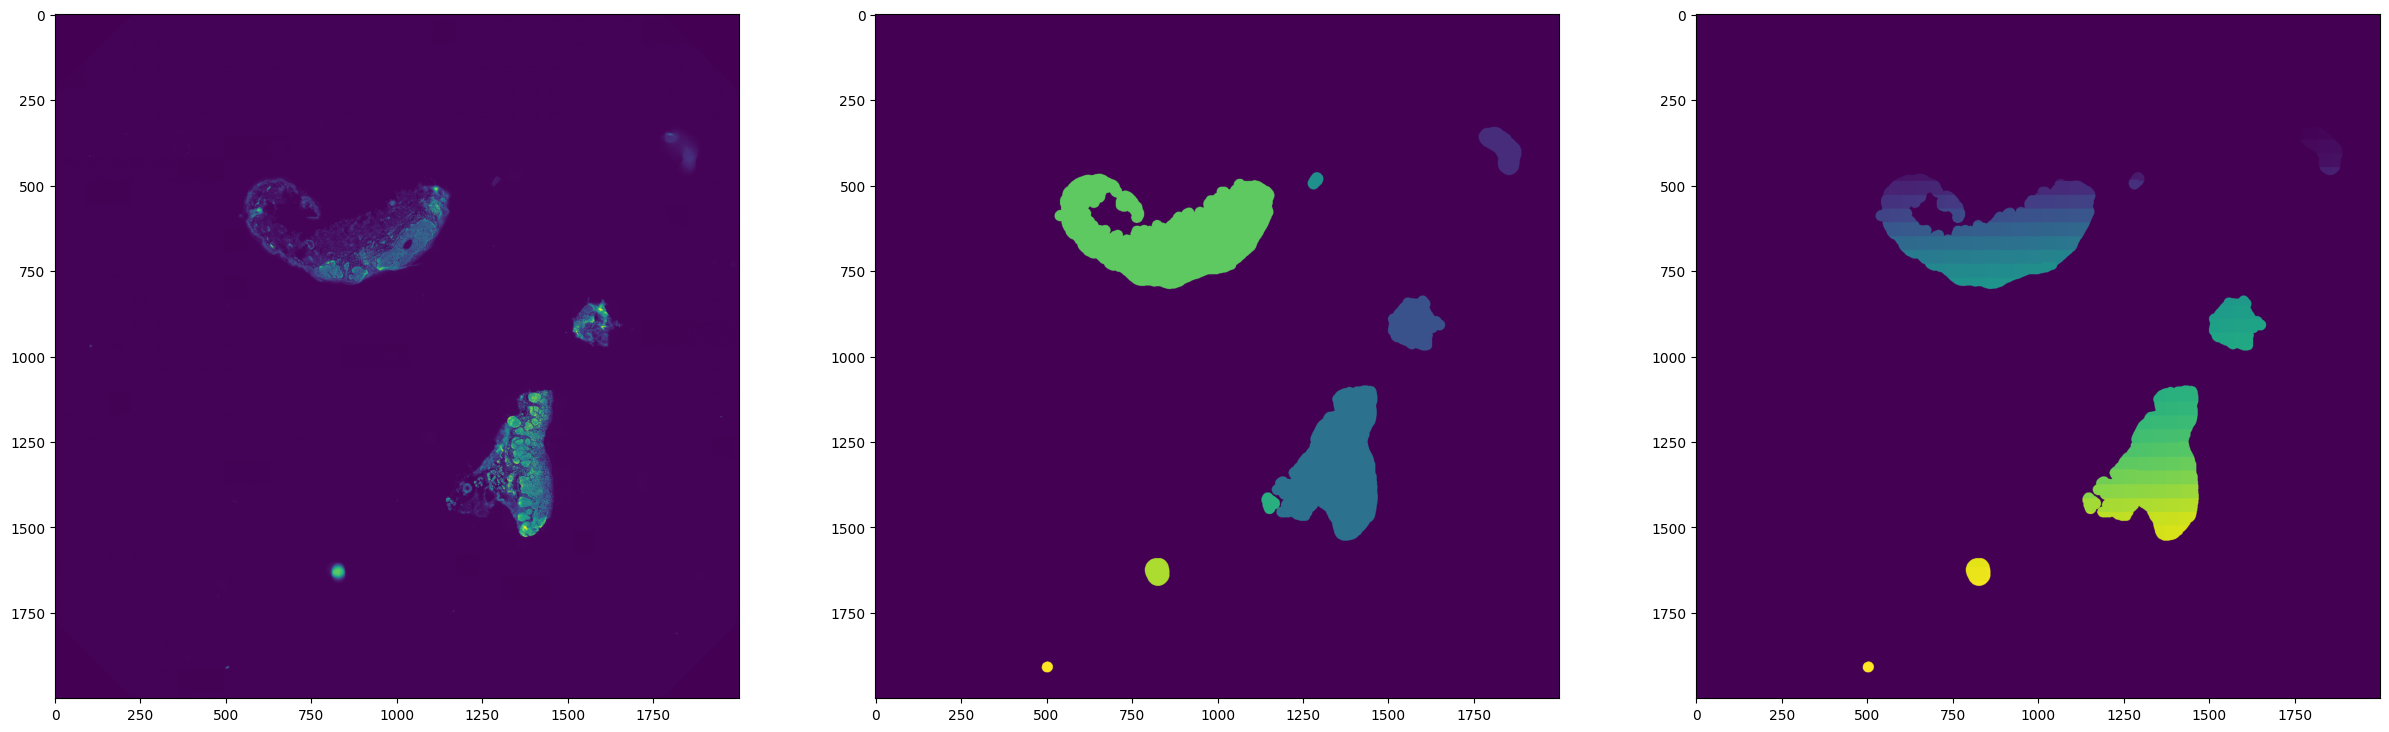

In [8]:
# DAPI Image, Tissue to be segmented, Segmentation patches
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(30, 10))
axs[0].imshow(img["comet_raster"].data.squeeze())
axs[1].imshow(img["tissue_raster"].data.squeeze())
axs[2].imshow(img["patches_raster"].data.squeeze())

In [ ]:
# Switch to an on-disk zarr object to improve performance by first writing and then reading
img.write(file_path="SOPA_PRESEG.zarr", overwrite=True)

## Segmentation

In [ ]:
# Switch to an on-disk zarr object to improve performance by first writing and then reading
img = sd.read_zarr("SOPA_PRESEG.zarr")
img

INFO     The Zarr backing store has been changed from None the new file path: SOPA_PRESEG.zarr                     


In [ ]:
# Perform the segmentation. Assumes that:
# - We are running on a GPU node
# - The cpsam model is present at: ~/.cellpose/models/cpsam (download from: https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam?download=true)
sopa.segmentation.cellpose(sdata=img, image_key="no_elution", channels=["Channel:0:0"],
                           diameter=20, gpu=True, delete_cache=True, recover=False,
                           flow_threshold=2, cellprob_threshold=-6, clip_limit=0.0,
                           clahe_kernel_size=None, gaussian_sigma=1, key_added="cells")

In [186]:
# Gets the mean pixel values for each channel in each cell as an AnnData object, no cells are discarded
sopa.aggregation.aggregate(img, image_key="no_elution", shapes_key="cells", aggregate_channels=True, min_intensity_ratio=0)

[INFO] (sopa.aggregation.channels) Aggregating channels intensity over 48230 cells with mode='average'


[########################################] | 100% Completed | 101.88 s


/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/spatialdata/_core/_elements.py:108: UserWarning: Key `cells` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [88]:
# Gets the mean pixel values for each channel in each cell as an AnnData object, no cells are discarded
img = img.subset(["no_elution", "cells", "image_patches", "region_of_interest", "table"])

In [6]:
# Switch to an on-disk zarr object to improve performance by first writing and then reading
img.write(file_path="SOPA_NO_ELUTION_SEG_FIX.zarr", overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside SOPA_NO_ELUTION_SEG_FIX.zarr). Please see the documentation of `is_self_contained()` to 
         understand the implications of working with SpatialData objects that are not self-contained.              
INFO     The Zarr backing store has been changed from SOPA_PRESEG.zarr the new file path:                          
         SOPA_NO_ELUTION_SEG_FIX.zarr                                                                              


## Analysis
If you have processed the data with the nf-core pipeline, you can start processsing from here.

In [2]:
# Switch to an on-disk zarr object to improve performance by first writing and then reading
img = sd.read_zarr("SOPA_NO_ELUTION_SEG_FIX.zarr")

version mismatch: detected: RasterFormatV02, requested: FormatV04
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHE

In [3]:
# Plot a small cropped area to check the segmentation
crop = img.query.bounding_box(axes = ("x", "y"), min_coordinate = [30000, 30000], max_coordinate = [31000, 31000], target_coordinate_system="global")
crop.pl.render_images("no_elution", channel='Channel:0:0').pl.render_shapes("cells", fill_alpha = 0, outline_width=1.5, outline_color='#FF0000', outline_alpha=1).pl.show()
del(crop)

ValueError: Invalid channel(s): Channel:0:0. Valid choices are: ['DAPI' 'CD3' 'FOXP3' 'CD4' 'CD8' 'CD20' 'CD56' 'CD11c' 'CD68' 'aSMA'
 'PDL1' 'CD45' 'PD1' 'Ki67']

In [ ]:
img["nodapi"] = img["table"][:, 1:].copy()

In [ ]:
# Plot violin plots for each marker expression across cells
sc.pl.violin(img["table"], sopa_marker_genes, rotation=90, log=True)

In [ ]:
sc.pp.neighbors(img["nodapi"])
sc.tl.umap(img["nodapi"])

In [ ]:
sc.tl.leiden(img["nodapi"], flavor="igraph", n_iterations=2, resolution = 0.3)

In [ ]:
sc.pl.umap(
    img["nodapi"],
    color="leiden")

In [ ]:
sc.pl.umap(
    img["nodapi"],
    color=sopa_marker_genes[1:], vmax = 500)

In [ ]:
marker_genes = {
    "Leukocyte (CD45)": ["CD45"],
    "T Cells (CD3)": ["CD3"],
    "Helper T Cells (CD4)": ["CD4"],
    "Cytotoxic T Cells (CD8)": ["CD8"],
    "Activated / Exhausted (PD-1)": ["PD1"], 
    "Regulatory T Cells (FOXP3)": ["FOXP3"],
    "NK Cells (CD56)": ["CD56"],
    "B Cells (CD20)": ["CD20"],
    "Macrophages (CD68)": ["CD68"],
    "Dendritic Cells (CD11c)": ["CD11c"],
    "Fibroblast (aSMA)": ["aSMA"],
    "Proliferating (Ki-67)": ["Ki67"],
    "Immunosuppressive (PDL1)": ["PDL1"]
    
}
sc.pl.dotplot(img["nodapi"], marker_genes, groupby="leiden", standard_scale="var", vmax = 1)

In [ ]:
sc.pl.heatmap(img["nodapi"], marker_genes, groupby='leiden', swap_axes=True, vmax=500)

In [ ]:
# Extract the bounding boxes of the 3 largest pieces of tissue:
# 1) Calculate the scaling factor between the pyramid level used for tissue segmentation and the full resolution
# 2) Get the bounding boxes from the regions_of_interest ROIs polygons we obtained from the tissue segmentation
# 3) Scale the bounding boxes to match the full resolution image
# 4) Calculate the area to find the 3 kargest bounding boxes
factor = img["no_elution"]["scale0"].dims["x"] / img["no_elution"]["scale4"].dims["x"]
samples =  img["region_of_interest"].bounds * factor
samples["area"] = (samples["maxx"] - samples["minx"]) * (samples["maxy"] - samples["miny"])
samples = samples.iloc[samples["area"].nlargest(3).index]
samples

In [ ]:
# Use the bounding boxes to crop the spatialdata object
sample_list = []
for i in range(len(samples)):
    minc = np.array((samples.iloc[i].minx, samples.iloc[i].miny))
    maxc = np.array((samples.iloc[i].maxx, samples.iloc[i].maxy))
    sample_list.append(img.query.bounding_box(axes=("x", "y"), min_coordinate=minc, max_coordinate=maxc, target_coordinate_system="global"))
sample_list

In [ ]:
# Write out zarrs for visualization with napari
outpath = "CROPPED"
os.makedirs(outpath, exist_ok=True)
for i in range(len(sample_list)):
    path  = os.path.join(outpath, "sample_" + str(i) + ".zarr")
    sample_list[i].write(file_path=path, overwrite=True)